# ToBig's 4주차 정규세션 2교시 추천시스템 과제
여러분 정규세션 듣는다고 고생 많으셨습니다. 😊

이번 과제는 간단하게 추천시스템의 여러 가지를 직접 구현해보는 쪽으로 만들어봤습니다. 총 3가지 실습입니다.

과제에 대해 궁금한 점이 있으시면 언제든지 23기 김상우, 문혜원에게 개인적으로 연락 주시면 됩니다!

###`'your_code'라고 쓰인 부분에 본인의 코드를 채워주시면 됩니다.`

## 1. 잠재 요인 기반 협업 필터링 (Latent Factor Collaborative Filtering) 실습
1번째는 추천 시스템의 협업 필터링 중에서 행렬 분해(Matrix Factorization)에 대한 실습입니다.

데이터는 Kaggle의 **The Movies Dataset** 데이터를 사용하였습니다.

https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=movies_metadata.csv

### Import Packages

In [1]:
# 실습에 필요한 패키지들 import
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Colab 기반
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Load

해당 movielens 데이터는 2개로 나뉘어져 있습니다.
1. `ratings.csv` : 사용자-영화 평점 기반 데이터
2. `movies.csv` : 영화 정보 데이터

In [3]:
rating_data = pd.read_csv('/content/drive/MyDrive/tobigs/week4/ratings.csv')
movie_data = pd.read_csv('/content/drive/MyDrive/tobigs/week4/movies.csv')

In [4]:
# 데이터들 각각 확인
display(rating_data.head(), movie_data.head())

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
display(movie_data.shape, rating_data.shape)

(9125, 3)

(100004, 4)

### Data Preprocessing


앞서 살펴본 결과 영화 평점 데이터는 10만개가 넘고, 영화 데이터는 9000여개가 존재합니다.

각각 데이터에 존재하는 timestamp와 genres는 잠재요인 기반 협업 필터링 추천 시스템에서는 필요없습니다.

###`Q1. drop을 이용해서 'timestamp'와 'genre'를 제거해주세요.`

In [6]:
# rating_data에서 'timestamp' 컬럼 제거
rating_data.drop('timestamp', axis = 1, inplace = True)
rating_data.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [7]:
# movie_data에서 'genres' 컬럼 제거
movie_data.drop('genres', axis = 1, inplace = True)
movie_data.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


필요없는 칼럼을 제거하였으니 이제 2개의 파일을 merge를 이용해서 합쳐줍니다. 2개의 데이터는 `movieId`라는 공통 컬럼이 존재합니다.

In [8]:
user_movie_data = pd.merge(rating_data, movie_data, on = 'movieId')
user_movie_data.head()

,userId,movieId,rating,title
0,1,31,2.5,Dangerous Minds (1995)
1,1,1029,3.0,Dumbo (1941)
2,1,1061,3.0,Sleepers (1996)
3,1,1129,2.0,Escape from New York (1981)
4,1,1172,4.0,Cinema Paradiso (Nuovo cinema Paradiso) (1989)


In [9]:
user_movie_data.shape

(100004, 4)

합친 결과 특정 유저가 영화에 대해 평점을 매겼는데 그 영화의 제목(title)이 무엇인지 알 수 있게 되었습니다.

현재 `user`, `movie`, `rating`이 각각 컬럼에 존재하는 상황입니다.

이렇게 생긴 데이터를 `value`를 평점으로 column은 `movie`로, row는 `userId`로 바꿔주려고 합니다.

###`Q2. pivot_table을 이용해서 변환해주세요.`

In [13]:
user_movie_rating = user_movie_data.pivot_table('rating', index = 'userId', columns='title').fillna(0)
# 사용자가 평점을 매지기 않은 정보에는 fillna을 사용해 0으로 채워줌

In [14]:
display(user_movie_rating.shape, user_movie_rating.head())

(671, 9064)

title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),...,Zulu (1964),Zulu (2013),[REC] (2007),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),İtirazım Var (2014)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


이제 사용자-영화 기준의 데이터를 **영화-사용자** 기준으로 만들어서 특정 '영화'와 비슷한 영화를 추천해주는 시스템을 구현해보도록 하겠습니다.

#### **즉 '특정 영화와 비슷한 영화를 추천'해주는 시스템을 의미합니다.**

이를 위해 현재 user-movie로 되어 있는 pivot_table을 movie-user 데이터로 바꿔줍니다.

In [15]:
movie_user_rating = user_movie_rating.values.T # 전치(transpose) 사용
movie_user_rating.shape

(9064, 671)

### SVD (특이값 분해)

여기서, SVD를 사용할 계획입니다.

**SVD(Singular Value Decomposition), 특이값 분해**란 m x n 크기의 데이터 행렬 A를 아래와 같이 분해하는 것을 말합니다.
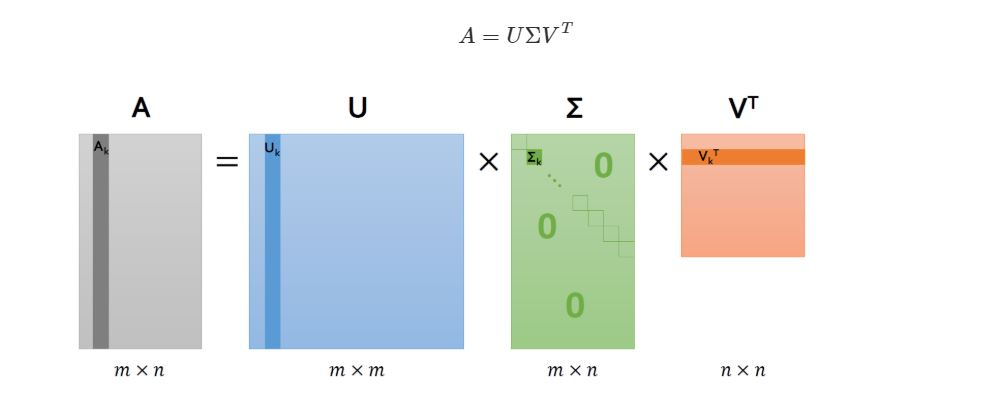

간단하게 설명하자면, 행렬 U와 V에 속한 열벡터는 특이벡터(singular vector)로 불리고, 이 특이벡터들은 서로 직교하는 성질을 가지고 있습니다.

또한, 가운데 시그마 기호로 보이는 것도 행렬인데, 이 행렬은 대각행렬(diagonal matrix) 성질을 가지고 있습니다.

그래서 대각 성분이 행렬 A의 특이값이고 나머지 성분이 0입니다.

우리가 사용할 방법인 **Truncated SVD**는 이러한 SVD의 변형입니다.

**Truncated SVD**는 시그마 행렬의 대각원소(특이값) 가운데 상위 n개만 골라낸 것입니다. 이렇게 하면 기존 행렬 A의 성질을 100% 원복할 수는 없지만, (그 만큼 데이터 정보를 압축) 행렬 A와 거의 근사한 값이 나오게 됩니다.

### `Q3. 'movie_user_rating' 데이터프레임을 이용하여, TruncatedSVD를 사용해 12차원으로 축소된 잠재 요인 행렬을 구해주세요.`

In [17]:
# scikit learn의 TruncatedSVD 사용
SVD = TruncatedSVD(n_components=12)
matrix = SVD.fit_transform(movie_user_rating)
matrix.shape

(9064, 12)

Latent 값을 12로 두어 12개의 component로 차원을 축소했습니다.

그리고, SVD.fit_transform을 통해 변환하게 되면 9064개의 영화 데이터가 12개의 어떤 요소의 값을 가지게 됩니다.

In [18]:
# component 확인
matrix[0]

array([ 0.01227491, -0.0025078 , -0.01554796,  0.03400638,  0.01446173,
       -0.00363729,  0.0022915 ,  0.0446548 , -0.0155883 , -0.02222247,
       -0.00912955,  0.00873819])

이렇게 나온 데이터를 활용해 피어슨 상관계수를 구하겠습니다.

In [19]:
corr = np.corrcoef(matrix)
corr.shape

(9064, 9064)

<Axes: >

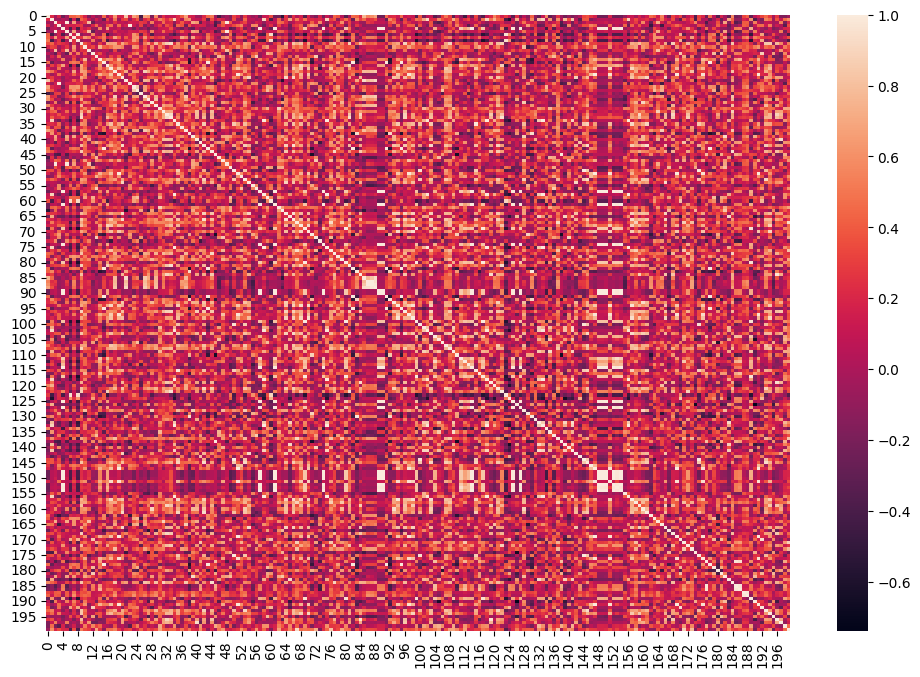

In [20]:
corr2 = corr[:200, :200]
corr2.shape
# seaborn의 heatmap 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(corr2)

seaborn의 heatmap을 사용하면 상관계수끼리의 관계를 한 눈에 파악할 수 있습니다.
여기서 대각선이 하얀색인 이유는 자기 자신과의 관계이기 때문에 가장 높은 하얀색이 나온 것입니다.

이렇게 나온 상관계수를 이용해서 '특정 영화'와 관련하여 상관계수가 높은 영화를 뽑아보도록 하겠습니다.

In [21]:
movie_title = user_movie_rating.columns
movie_title_list = list(movie_title)
coffey_hands = movie_title_list.index("Guardians of the Galaxy (2014)")

In [22]:
corr_coffey_hands  = corr[coffey_hands]
list(movie_title[(corr_coffey_hands >= 0.9)])[:20]

['2 Guns (2013)',
 '2012 (2009)',
 '300: Rise of an Empire (2014)',
 'Abduction (2011)',
 'Adjustment Bureau, The (2011)',
 'Adventures of Tintin, The (2011)',
 'Alice in Wonderland (2010)',
 'Amazing Spider-Man, The (2012)',
 'Ant-Man (2015)',
 'Avatar (2009)',
 'Avengers, The (2012)',
 'Avengers: Age of Ultron (2015)',
 'Batman: The Dark Knight Returns, Part 1 (2012)',
 'Batman: The Dark Knight Returns, Part 2 (2013)',
 'Battle: Los Angeles (2011)',
 'Bee Movie (2007)',
 'Big Hero 6 (2014)',
 'Bolt (2008)',
 'Brave (2012)',
 'Captain America: Civil War (2016)']

마블의 가디언즈 오브 갤럭시를 지정하여 상관계수가 높은 영화들을 뽑은 결과

**마블 어벤져스, 캡틴 아메리카, 배트맨 등**이 결과로 나온 걸로 봐서 비슷하게 추천되었다고 볼 수 있겠습니다.

## 2. 아이템 기반 협업 필터링 실습

### Data Load

In [23]:
rating_data = pd.read_csv('/content/drive/MyDrive/tobigs/week4/ratings.csv')
movie_data = pd.read_csv('/content/drive/MyDrive/tobigs/week4/movies.csv')

In [24]:
display(rating_data.head(), movie_data.head())

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Data Preprocessing

In [25]:
# rating_data에서 'timestamp' 컬럼 제거
rating_data.drop('timestamp', axis = 1, inplace = True)
# movie_data에서 'genres' 컬럼 제거
movie_data.drop('genres', axis = 1, inplace = True)

In [26]:
# 데이터 합치기
user_movie_rating = pd.merge(rating_data, movie_data, on = 'movieId')
user_movie_rating.head(2)

,userId,movieId,rating,title
0,1,31,2.5,Dangerous Minds (1995)
1,1,1029,3.0,Dumbo (1941)


In [27]:
# pivot_table 적용
movie_user_rating = user_movie_rating.pivot_table('rating', index = 'title', columns='userId')
user_movie_rating = user_movie_rating.pivot_table('rating', index = 'userId', columns='title')
movie_user_rating.fillna(0, inplace = True)

- movie_user_rating: 행=영화, 열=사용자, 값=평점

  → 각 영화가 어떤 사용자에게 어떤 평점을 받았는지
- user_movie_rating: 행=사용자, 열=영화, 값=평점

  → 각 사용자가 어떤 영화에 어떤 평점을 줬는지
- 결측치(NaN)는 아직 평가되지 않은 영화이므로 0으로 채움

In [ ]:
display(user_movie_rating.head(), movie_user_rating.head())

title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),...,Zulu (1964),Zulu (2013),[REC] (2007),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),İtirazım Var (2014)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
title,,,,,,,,,,,,,,,,,,,,,
"""Great Performances"" Cats (1998)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
$9.99 (2008),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Neath the Arizona Skies (1934),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### `Q1. 아이템 간 코사인 유사도를 계산해주세요.`

In [28]:
# 아이템 간 유사도 계산
item_based_collabor = cosine_similarity(movie_user_rating)
item_based_collabor

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.05821787, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.05821787, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [29]:
print(movie_user_rating.shape)
print(item_based_collabor.shape)

(9064, 671)
(9064, 9064)


In [30]:
# 추천 함수 정의
item_based_collabor = pd.DataFrame(data = item_based_collabor, index = movie_user_rating.index, columns = movie_user_rating.index)
item_based_collabor.head()

title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),...,Zulu (1964),Zulu (2013),[REC] (2007),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),İtirazım Var (2014)
title,,,,,,,,,,,,,,,,,,,,,
"""Great Performances"" Cats (1998)",1.000000,0.0,0.0,0.164399,0.020391,0.0,0.014046,0.000000,0.0,0.003166,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
$9.99 (2008),0.000000,1.0,0.0,0.000000,0.000000,0.0,0.000000,0.079474,0.0,0.156330,...,0.0,0.0,0.0,0.000000,0.0,0.013899,0.0,0.058218,0.0,0.0
'Hellboy': The Seeds of Creation (2004),0.000000,0.0,1.0,0.000000,0.000000,1.0,0.000000,0.217357,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
'Neath the Arizona Skies (1934),0.164399,0.0,0.0,1.000000,0.124035,0.0,0.085436,0.000000,0.0,0.019259,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
'Round Midnight (1986),0.020391,0.0,0.0,0.124035,1.000000,0.0,0.010597,0.143786,0.0,0.136163,...,0.0,0.0,0.0,0.121567,0.0,0.000000,0.0,0.000000,0.0,0.0


In [31]:
def get_item_based_collabor(title):
    return item_based_collabor[title].sort_values(ascending=False)[:6]

# 해당 영화와 평점 패턴이 비슷한 영화 출력
get_item_based_collabor('Godfather, The (1972)')

,"Godfather, The (1972)"
title,
"Godfather, The (1972)",1.000000
"Godfather: Part II, The (1974)",0.773685
Goodfellas (1990),0.620349
One Flew Over the Cuckoo's Nest (1975),0.568244
American Beauty (1999),0.557997
Star Wars: Episode IV - A New Hope (1977),0.546750


# 3. 실제 패션 데이터를 이용한 추천시스템 실습
마지막으로 Ai-Hub에서 제공하는 **상품 리뷰데이터**를 사용해 간단한 데이터 EDA와 추천시스템 구현을 해보고자 합니다.

데이터셋 링크는 다음과 같습니다.

https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&searchKeyword=%EC%86%8D%EC%84%B1%EA%B8%B0%EB%B0%98%20%EA%B0%90%EC%A0%95%EB%B6%84%EC%84%9D%20%EB%8D%B0%EC%9D%B4%ED%84%B0&aihubDataSe=data&dataSetSn=71603

우리는 여기서 `"패션 아이템 SNS 리뷰 데이터"` 를 이용하려고 합니다!

아무래도 간단한 실습이다보니, 데이터 EDA와 간단한 모델 적용에 중점을 준 점 양해부탁드립니다. 😅


## Import Packages

시각화를 했을때 한글이 깨지는 경우 하단 패키지 설치 코드를 실행한 다음, **`런타임 초기화 후 다시 시작`** 하면 한글이 깨지지 않습니다!

In [32]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 4s (2,484 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126374 files and dire

In [33]:
# Word2Vec을 위한 패키지 설치
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 19.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatibl

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec

In [2]:
# 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

## Load Data

In [3]:
# 경로는 각자 맞게 변경해주세요
train = pd.read_excel("/content/drive/MyDrive/tobigs/week4/Train_SNS_패션.xlsx")

In [4]:
# 컬럼 표준화
train = train.rename(columns={"상품명":"item_name","상품평":"review","카테고리":"category"})

In [5]:
# 데이터 확인
display(train.head())

,INDEX,도메인,category,item_name,review,데이터구분
0,1024338,패션,여성의류,OO 경량 다운 자켓,안녕하세요 이웃님들 반갑습니다. 요즘 날씨가 많이 쌀쌀해졌죠? 요즘 계절에 입으면 ...,SNS
1,1024477,패션,여성의류,OO 아** 구스코트,드디어 겨울이 찾아왔네요. 이제부터 슬슬 겨울 패딩 장만하셔야지요?\n패딩 소개해 ...,SNS
2,1025044,패션,여성의류,OO 아** 구스코트,오늘도 정말 춥네요... 롱패딩 찾고 계신 분을 위한 후기 공유합니다.\n\n키 1...,SNS
3,1025046,패션,여성의류,OO 아** 구스코트,이웃님들 오늘도 안녕하신가요? 오늘은 따끈한 신상 패딩 후기 올려봅니다~~\n\n겨...,SNS
4,1025071,패션,여성의류,OO 아** 구스코트,OOO 구스로 소문난 OO의 롱패딩~ 한번 구경 가봐요.\n\n일단 보는 순간 고급...,SNS


## EDA (데이터 분석)

In [6]:
# 크기 및 결측치 개수 확인
print("Train 크기:", train.shape)
print("\n결측치 개수:\n", train.isnull().sum())

Train 크기: (3890, 6)

결측치 개수:
 INDEX         0
도메인           0
category      0
item_name    10
review        0
데이터구분         0
dtype: int64


In [7]:
# 중복 리뷰 개수 확인
dup_count = train.duplicated().sum()
print(f"중복 행 개수: {dup_count}")

중복 행 개수: 0


### `Q1. 빈칸에 본인의 코드를 채워, 패션 카테고리의 분포를 시각화해주세요.`

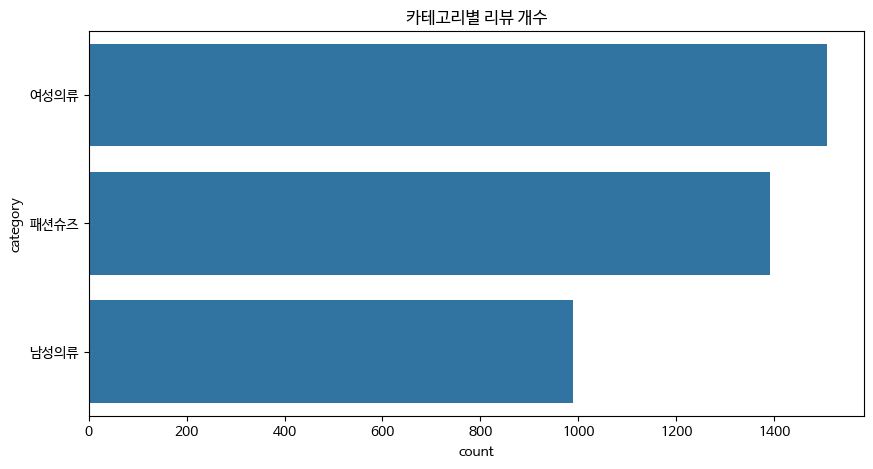

In [12]:
# 카테고리 분포 시각화
plt.figure(figsize=(10,5))
sns.countplot(y='category', data=train, order=train['category'].value_counts().index)
plt.title("카테고리별 리뷰 개수")
plt.show()

In [13]:
# 카테고리별 평균 리뷰 길이 확인
print("\n카테고리별 평균 리뷰 길이:")
print(train.groupby("category")["review"].apply(lambda x: np.mean([len(str(r)) for r in x])))


카테고리별 평균 리뷰 길이:
category
남성의류    298.935354
여성의류    312.692971
패션슈즈    319.507184
Name: review, dtype: float64


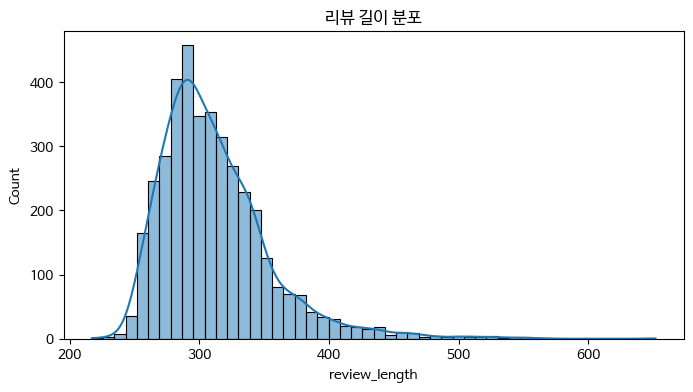

In [14]:
# 리뷰 길이 분포 시각화
train["review_length"] = train["review"].astype(str).apply(len)
plt.figure(figsize=(8,4))
sns.histplot(train["review_length"], bins=50, kde=True)
plt.title("리뷰 길이 분포")
plt.show()

In [15]:
# 가장 긴 리뷰 / 가장 짧은 리뷰 확인
print("가장 긴 리뷰 예시:\n", train.loc[train["review_length"].idxmax(),"review"])
print("\n가장 짧은 리뷰 예시:\n", train.loc[train["review_length"].idxmin(),"review"])

가장 긴 리뷰 예시:
 안녕하세요 이웃님들~~ 요즘 머스트잇템 OOO슈퍼스타, 너무 예쁜데 가격이 사악해 구매가 망설여지죠? 그럴 줄 알고 제가 내돈내산 구매 후기 작성합니다. 오늘 OOO 슈퍼 스타 낱낱이 분석해 드릴게요.지금 바로 Go Go Go~

빈티지 슈즈의 레전드답게 신으면 너무 너무 예쁩니다. 빈티지인데 고급스러워 보이는 이 신기한 마술~~신발에 스크래치가 있는건 알고 있었지만 뒷쪽 은색부분이 벗겨져 있어서 문의 했더니 이마저도 OOO만의 특성이라 하네요. 저같은 분들 참고하시길요. 바지,치마,트레이닝복 모든 옷에 다 잘 어울립니다. 트레이닝복과 함께 장착해도 무심한 듯 흐르는 멋스러움과 고급스러움! 이 맛에 OOO 신는 듯요. 사이즈는 평소 235신는데  2cm가량의 굽이 있어서 37 사이즈 정사이즈로 잘 맞네요. 36도 맞을수 있다고는 하는데 너무 딱 맞아 착화감을 고려해서 37사이즈 추천합니다. 아쉬운 점은 OOO의 단점인 밑바닥이 지우개(?)라 불리우듯 내구성이 안좋은 점입니다. 그렇지만 이점은 밑창 보강하거나 슈구를 발라서 해결할수 있고 보강가격도 예전에 비해 많이 착해져서 부담없이 하실수 있어요.

오늘 준비한 소식은 여기까지입니다. 이웃님들 마음에 드셨나요? 도움이 되셨다면 좋아요 꾹~ 잊지 마세요. 여러분의 지지와 격려는 저에게 큰 힘이 됩니다.

가장 짧은 리뷰 예시:
 날씨가 흐려서 제 마음도 흐린 것 같아요 
이웃님들은 마음은 흐리지 않도록 제가 활기찬 내용으로 도와 드릴께요

디자인이 예뻐서 고심끝에 평소 사이즈 105를 구매했어요 상의는 좀 큰감이 있지만 하의는 좀 작아요 105는 좀 여유핏이 납니다 전체적으로 상의는 크게 하의는 작게 나왔어요

제 글을 끝까지 읽어주시니 너무 너무 감사하네요 
다음번에도 기분 좋은 내용으로 다시 찾아 오겠습니다


### `Q2. 빈칸에 본인의 코드를 채워, 상품별 리뷰 개수 Top-10을 시각화해주세요.`


리뷰가 가장 많은 상품 Top-10:
 item_name
OO 오** 메리제인 구두         15
OO 클** 부츠              15
OO 여성 소가죽 다이얼 스니커즈     15
OO 싱글 울 코트             14
OO 코튼 가디건              14
OO 여성 소가죽 샌들           13
OO 아** 구스코트            13
OO 모** 삭스 앵클부츠         13
OO 브** 터틀넥 긴팔티         13
OO 젠** 싱글 재킷           13
Name: count, dtype: int64


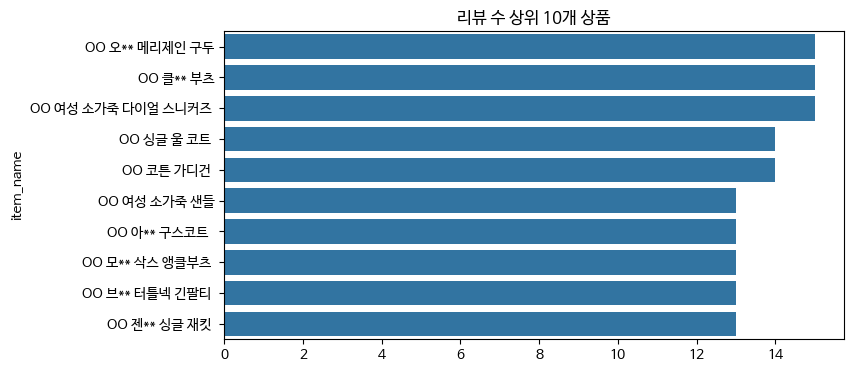

In [44]:
# 상품별 리뷰 개수 Top-10 출력
top_items = train["item_name"].value_counts().head(10)
print("\n리뷰가 가장 많은 상품 Top-10:\n", top_items)
# 시각화
plt.figure(figsize=(8,4))
sns.barplot(x=top_items.values , y=top_items.index)
plt.title("리뷰 수 상위 10개 상품")
plt.show()

## 심화 EDA

### 1. 카테고리별 텍스트 차이 분석
카테고리별 텍스트 차이를 분석하기 위해, TF-IDF을 사용해 자주 등장하는 단어 Top-N을 뽑아 인사이트를 도출하고자 합니다.

###` Q3. 주석(#)을 참고하여 빈칸에 본인의 코드를 채워 함수를 구현해주세요.`

In [46]:
# 카테고리별 상위 단어 출력 함수
def top_keywords_by_category(df, category_col="category", text_col="review", topn=10):
    # TF-IDF 벡터라이저 선언
    tfidf = TfidfVectorizer(max_features=5000)
    # 카테고리 값별로 분리 -> 리뷰가 5개 미만이면 제외
    for cat in df['category'].unique():
        sub = df[df[category_col]==cat]
        if len(sub) < 5 : continue
        # TF-IDF 변환 -> 상위 키워드 추출
        X = tfidf.fit_transform(sub[text_col]) # 리뷰 텍스트를 TF-IDF 벡터로 변환

        # 상위 단어 뽑기
        idx = np.asarray(X.sum(axis=0)).ravel().argsort()[::-1][:topn]
        terms = np.array(tfidf.get_feature_names_out())[idx] # 실제 단어 리스트 반환
        print(f"\n[카테고리: {cat}] Top {topn} 단어:")
        print(", ".join(terms))

top_keywords_by_category(train)


[카테고리: 여성의류] Top 10 단어:
너무, 정말, 좋은, 같아요, ooo, 입고, 입을, 있는, 추천, 같습니다

[카테고리: 남성의류] Top 10 단어:
너무, 같습니다, 합니다, 좋습니다, 좋은, 후기를, 아주, 마음에, 조금, 같아요

[카테고리: 패션슈즈] Top 10 단어:
너무, 신고, 정말, 신발, 좋은, ooo, 같아요, 발이, 좋습니다, 제가


### 2. 상품별 리뷰 감정 분포 (긍정/부정 단어 기반 간이 감정 스코어)
상품별 리뷰 감정 분포를 확인하기 위해, 지금은 원천 데이터라 라벨링 데이터가 없지만, 간단한 감정 리스트를 만들어 리뷰 감정 분포를 확인해보고자 합니다.

###` Q4. 빈칸에 본인의 코드를 채워서, 감정 점수 분포를 시각화해주세요.`

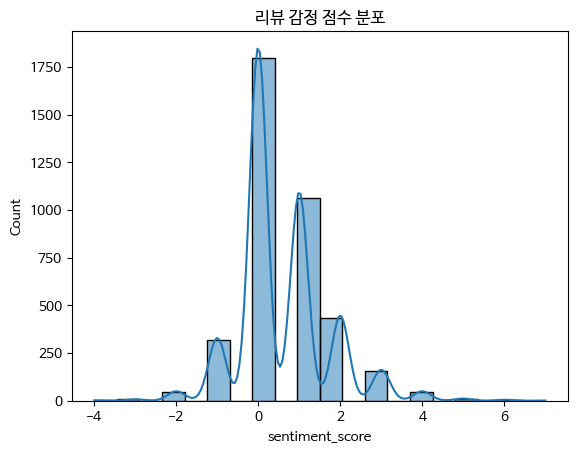

item_name
OO 캐시미어 코트       7.0
OO 스탠카라 패딩코트     5.0
OO 램** 로퍼남성      4.0
OO 체** 셔츠        3.0
OO 밴딩 기모팬츠       3.0
Name: sentiment_score, dtype: float64


In [48]:
# 감정 단어 사전 리스트(긍정, 부정)
positive_words = ["좋다","만족","편하다","추천","최고"]
negative_words = ["별로","불편","실망","나쁘다","환불"]

# 감정 점수 계산 함수
def sentiment_score(text):
    text = str(text)
    pos = sum([text.count(w) for w in positive_words])
    neg = sum([text.count(w) for w in negative_words])
    return pos - neg

# 리뷰별 감정 점수 계산
train["sentiment_score"] = train["review"].apply(sentiment_score)

# 감정 점수 분포 시각화
sns.histplot(train["sentiment_score"], bins=20, kde=True)
plt.title("리뷰 감정 점수 분포")
plt.show()

# 'item_name' 기준 상품별 평균 감정 점수 Top-5
print(train.groupby("item_name")["sentiment_score"].mean().sort_values(ascending=False).head())

히스토그램으로 각 리뷰의 감정 점수가 출력되게 됩니다.

분포 해석 :
- 오른쪽으로 치우치면 긍정 리뷰가 많음
- 왼쪽으로 치우치면 부정 리뷰가 많음
- 0 근처에 몰려 있으면 긍,부정 단어가 거의 없거나 균형을 의미합니다.

### 3. 리뷰 다양성(Diversity) 측정
리뷰들이 단순 복붙 패턴, 짧은 패턴으로 반복되는지, 다양한 단어들로 쓰였는지 확인하기 위해 리뷰 다양성을 측정해보고자 합니다.

In [49]:
# 리뷰 다양성 측정 함수
def review_diversity(texts):
    vec = CountVectorizer() # 텍스트 안에 등장하는 모든 단어를 "단어 카운트 행렬"로 변환
    X = vec.fit_transform(texts)
    return X.shape[1] / X.shape[0]  # 고유단어수/리뷰수 비율

div_scores = (train.groupby("item_name")["review"]
              .apply(review_diversity)
              .sort_values(ascending=False))

print("리뷰 다양성이 높은 상품 Top-5:\n", div_scores.head())
print("결과 해석 : 리뷰 한 건당 평균적으로 몇 개의 고유 단어가 쓰였는지를 나타내는 결과")

리뷰 다양성이 높은 상품 Top-5:
 item_name
OO 스니커즈           103.0
OO 소가죽 스니커즈       102.0
OO 슈** 스니커즈        88.0
OO 컨버스화            87.5
OO 베** 소가죽 로퍼      86.0
Name: review, dtype: float64
결과 해석 : 리뷰 한 건당 평균적으로 몇 개의 고유 단어가 쓰였는지를 나타내는 결과


# Data Preprocessing (데이터 전처리)

In [50]:
# 텍스트 전처리 -> 한글, 영문, 숫자만 남기기
def clean_text(text):
    text = str(text)
    text = re.sub(r"[^가-힣0-9a-zA-Z ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# 전처리한 컬럼 생성
train["clean_review"] = train["review"].apply(clean_text)

In [51]:
# 결측치 제거
train = train.dropna(subset=["item_name","clean_review","category"])

In [52]:
# 상품명도 통일 (공백, 특수문자 제거)
train["item_name"] = train["item_name"].astype(str).str.strip()

/tmp/ipython-input-2255720420.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["item_name"] = train["item_name"].astype(str).str.strip()


In [53]:
# 아이템 단위 문서 생성
train_docs = (train
              .groupby(["item_name","category"])["clean_review"]
              .apply(lambda s: " ".join(s.dropna().astype(str)))
              .reset_index())

print("아이템 단위 문서 수:", len(train_docs))

아이템 단위 문서 수: 1270


In [54]:
# 전처리 후 데이터 확인
train_docs.head()

,item_name,category,clean_review
0,OO 통굽 털슬리퍼 키높이 겨울슬리퍼 거실화,패션슈즈,찬바람 불면 발이 제일 먼저 알죠 편한 실내화 하나 소개해 드릴게요 엄마가 주택에 ...
1,OO 3way 소가죽 니트부츠,패션슈즈,안녕하세요 오늘 아침엔 갑자기 너무 쌀쌀해져서 출근길에 부츠가 신고 싶어지더라구요 ...
2,OO 3센치 여성 소가죽 앵클부츠,패션슈즈,전 가을이 되면 발목까지 오는 부츠 신는걸 즐기는 편인데요 최근에 산 첼시부츠에 대...
3,OO 7부 마 셔츠,남성의류,주변에서 너무 좋다는 칭찬이 많아서 직접 구매해서 입어본 솔직한 후기를 지금부터 적...
4,OO 8cm키높이슬립온 울** 블랙/화이트,패션슈즈,키높이라 키가 커보이고 편하게 신을수 있어서 주위분들에게 적극 권해드리고 싶은 신발...


### +) 전처리 후 카테고리별 대표 상품 찾기

In [55]:
from sklearn.metrics import pairwise_distances_argmin_min

tfidf = TfidfVectorizer(max_features=5000)
# 카테고리별 데이터 나누기
print("<카테고리별 대표 상품 목록>")
for cat in train_docs["category"].unique():
    sub = train_docs[train_docs["category"]==cat]
    if len(sub) < 5: continue
    # 카테고리 내 상품들의 리뷰 벡터화
    X_sub = tfidf.fit_transform(sub["clean_review"])
    # 카테고리 중심 벡터 : 해당 카테고리를 가장 잘 대표하는 단어 분포를 가진 가상의 벡터를 의미
    centroid = np.asarray(X_sub.mean(axis=0))
    # 대표 상품 찾기
    closest, _ = pairwise_distances_argmin_min(centroid, X_sub)
    rep_item = sub.iloc[closest[0]]["item_name"]
    print(f"[카테고리: {cat}] 대표 상품:", rep_item)

<카테고리별 대표 상품 목록>
[카테고리: 패션슈즈] 대표 상품: OO 바** 클로그 샌들
[카테고리: 남성의류] 대표 상품: OO 프** 다운 숏 패딩점퍼
[카테고리: 여성의류] 대표 상품: OO 폭스퍼 후드 구스 다운


## 추천시스템 적용 실습

### 1. 콘텐츠 기반 추천시스템

###` Q5. 주석(#)을 참고하여 빈칸에 본인의 코드를 채워 함수를 구현해주세요.`

In [62]:
# TF-IDF 콘텐츠 기반 추천 (TF-IDF + Cosine)
tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1,2), min_df=2, max_df=0.8)
X_tfidf = tfidf.fit_transform(train_docs["clean_review"])

# 추천할 때 문자열(상품명)로 입력받고, 내부적으로는 벡터 인덱스 사용
id2idx = {name:i for i,name in enumerate(train_docs["item_name"])}
idx2name = {i:name for name,i in id2idx.items()}

def recommend_tfidf(item_name, topk=10):
    """TF-IDF 기반 콘텐츠 추천"""
    if item_name not in id2idx:
        return pd.DataFrame()
    idx = id2idx[item_name] # 입력 아이템 인덱스
    sims = cosine_similarity(X_tfidf[idx], X_tfidf).ravel() # 코사인 유사도
    sims[idx] = -1
    top_idx = sims.argsort()[::-1][:topk] # 상위 Top-k 유사 상품 인덱스
    recs = train_docs.iloc[top_idx][["item_name","category"]].copy()
    recs["similarity"] = sims[top_idx] # 유사도 점수
    return recs
# "소가죽 니트부츠" 상품과 유사도가 가장 높은 상품 5개 추천
print(recommend_tfidf("OO 3way 소가죽 니트부츠", topk=5))

                   item_name category  similarity
1230  OO 하** 소가죽 니트 3-WAY 부츠     패션슈즈    0.143520
498             OO 스** 삭스 부츠     패션슈즈    0.133888
134                  OO 니트부츠     패션슈즈    0.116190
1138            OO 파** 니트 부츠     패션슈즈    0.106128
460       OO 소가죽 스웨이드 울니트 부츠     패션슈즈    0.088472


### 2. 카테고리별 인기 상품 추천시스템

### `Q6. groupby함수을 사용해 train에서 카테고리별, 상품별 리뷰 개수를 집계하여 테이블을 만들어주세요.`

In [63]:
# 카테고리별 각 상품의 리뷰 개수 테이블 생성
popularity = (train.groupby(["category","item_name"])["review"]
              .count()
              .reset_index(name="review_count"))

popularity.head()

,category,item_name,review_count
0,남성의류,OO 7부 마 셔츠,1
1,남성의류,OO 9부 코튼 린넨 밴딩 팬츠,1
2,남성의류,OO 경량 구스다운 하이넥베스트,3
3,남성의류,OO 경량다운 브이넥 베스트,1
4,남성의류,OO 경량다운 시** 베스트,6


In [64]:
# 카테고리별 Top-N 추천 함수
def recommend_popular(category, topk=5):
    sub = popularity[popularity["category"] == category]
    return sub.sort_values("review_count", ascending=False).head(topk)

print("남성의류 인기 Top-5:")
print(recommend_popular("남성의류", topk=5))
print("여성의류 인기 Top-5:")
print(recommend_popular("여성의류", topk=5))

남성의류 인기 Top-5:
    category         item_name  review_count
230     남성의류      OO 젠** 싱글 재킷            14
163     남성의류        OO 싱글 울 코트            14
209     남성의류         OO 울** 팬츠            12
227     남성의류  OO 자** 카라 반팔 티셔츠            12
60      남성의류      OO 레** 후드티셔츠            11
여성의류 인기 Top-5:
    category        item_name  review_count
784     여성의류        OO 코튼 가디건            14
351     여성의류      OO 경량 다운 자켓            14
575     여성의류      OO 아** 구스코트            13
498     여성의류   OO 브** 터틀넥 긴팔티            13
830     여성의류  OO 폭스퍼 후드 구스 다운            12


### 3. Word2Vec 임베딩 기반 추천시스템

In [65]:
# 리뷰 토큰화 & Word2Vec 학습
sentences = train["clean_review"].dropna().astype(str).apply(lambda x: x.split()).tolist()
w2v = Word2Vec(sentences, vector_size=100, window=5, min_count=5, sg=1, epochs=20)

# 상품별 리뷰 임베딩 만들기
item_vecs = {}
for item, group in train.groupby("item_name"):
    tokens = " ".join(group["clean_review"].dropna().astype(str)).split()
    vecs = [w2v.wv[w] for w in tokens if w in w2v.wv]
    if vecs:
        item_vecs[item] = np.mean(vecs, axis=0)

# item 리스트 & 행렬 구성
items = list(item_vecs.keys())
matrix = np.vstack([item_vecs[it] for it in items])

# 추천 함수 정의
def recommend_w2v(item_name, topk=5):
    if item_name not in items: return ['No data']
    idx = items.index(item_name)
    sims = cosine_similarity([matrix[idx]], matrix).ravel()
    sims[idx] = -1  # 자기 자신 제외
    top_idx = sims.argsort()[::-1][:topk]

    recs = pd.DataFrame({
        "item_name": [items[i] for i in top_idx],
        "category": [train_docs.set_index("item_name").loc[items[i], "category"] for i in top_idx],
        "similarity": [sims[i] for i in top_idx]
    })
    return recs


target_item = "OO 소가죽 니트부츠"   # 추천 받을 상품명 입력
print("기준 상품:", target_item)
display(recommend_w2v(target_item, topk=5))

기준 상품: OO 소가죽 니트부츠


,item_name,category,similarity
0,OO 니트부츠,패션슈즈,0.969262
1,OO 소가죽 로퍼,패션슈즈,0.965541
2,OO 프** 소가죽 스니커즈 (여성),패션슈즈,0.963606
3,OO 볼** 천연소가죽 기모 여성 앵클부츠,패션슈즈,0.963579
4,OO 라텍스 슬립온 슈즈,패션슈즈,0.963055


## 3가지 추천시스템 비교, 분석
앞서 우리가 구현한 3가지 (콘텐츠 기반 / 카테고리 인기 / Word2Vec) 추천 결과 테이블을 생성해보겠습니다.

In [66]:
def compare_recommendations(item_name, topk=5):
    results = []

    # 1. TF-IDF 콘텐츠 기반 추천
    tfidf_recs = recommend_tfidf(item_name, topk=topk)
    if isinstance(tfidf_recs, pd.DataFrame) and not tfidf_recs.empty:
        for _, row in tfidf_recs.iterrows():
            results.append({
                "기준 상품": item_name,
                "추천 방식": "콘텐츠 기반 (TF-IDF)",
                "추천 상품": row["item_name"],
                "카테고리": row["category"],
                "점수/유사도": row["similarity"]
            })

    # 2. 카테고리별 인기 상품 추천
    if item_name in train_docs["item_name"].values:
        category = train_docs.loc[train_docs["item_name"]==item_name, "category"].iloc[0]
        popular_recs = recommend_popular(category, topk=topk)
        if isinstance(popular_recs, pd.DataFrame) and not popular_recs.empty:
            for _, row in popular_recs.iterrows():
                results.append({
                    "기준 상품": item_name,
                    "추천 방식": f"카테고리 인기 (category={category})",
                    "추천 상품": row["item_name"],
                    "카테고리": row["category"],
                    "점수/유사도": row["review_count"]
                })

    # 3. Word2Vec 임베딩 기반 추천
    w2v_recs = recommend_w2v(item_name, topk=topk)
    if isinstance(w2v_recs, pd.DataFrame) and not w2v_recs.empty:
        for _, row in w2v_recs.iterrows():
            results.append({
                "기준 상품": item_name,
                "추천 방식": "Word2Vec 임베딩",
                "추천 상품": row["item_name"],
                "카테고리": row["category"],
                "점수/유사도": row["similarity"]
            })

    return pd.DataFrame(results)


In [67]:
# 비교할 기준 상품 입력
target_item = "OO 소가죽 니트부츠"
compare_table = compare_recommendations(target_item, topk=5)
display(compare_table)

,기준 상품,추천 방식,추천 상품,카테고리,점수/유사도
0,OO 소가죽 니트부츠,콘텐츠 기반 (TF-IDF),OO 소가죽 로퍼,패션슈즈,0.195588
1,OO 소가죽 니트부츠,콘텐츠 기반 (TF-IDF),OO 소가죽 컴포트 부츠(남성),패션슈즈,0.177288
2,OO 소가죽 니트부츠,콘텐츠 기반 (TF-IDF),OO 니트부츠,패션슈즈,0.170999
3,OO 소가죽 니트부츠,콘텐츠 기반 (TF-IDF),OO 여성 소가죽 샌들,패션슈즈,0.151509
4,OO 소가죽 니트부츠,콘텐츠 기반 (TF-IDF),OO 프** 소가죽 스니커즈 (여성),패션슈즈,0.149982
5,OO 소가죽 니트부츠,카테고리 인기 (category=패션슈즈),OO 여성 소가죽 다이얼 스니커즈,패션슈즈,15.000000
6,OO 소가죽 니트부츠,카테고리 인기 (category=패션슈즈),OO 오** 메리제인 구두,패션슈즈,15.000000
7,OO 소가죽 니트부츠,카테고리 인기 (category=패션슈즈),OO 클** 부츠,패션슈즈,15.000000
8,OO 소가죽 니트부츠,카테고리 인기 (category=패션슈즈),OO 여성 소가죽 샌들,패션슈즈,14.000000
9,OO 소가죽 니트부츠,카테고리 인기 (category=패션슈즈),OO 모** 삭스 앵클부츠,패션슈즈,13.000000


## <서술형 문제>

###문제1:

> 동일한 기준 상품 "OO 소가죽 니트부츠"를 대상으로
TF-IDF 콘텐츠 기반, 카테고리 인기 기반, Word2Vec 임베딩 기반 추천 시스템의 결과를 비교했을 때,
각 방법이 어떤 기준으로 추천을 수행하는지 서술해주세요.

답안 : TF-IDF는 단어 유사도, 카테고리 인기 기반은 특정 집단의 선호도, Word2Vec은 단어의 의미적 유사성을 기반으로 추천함.   

### 문제2

> 콘텐츠 기반 추천(TF-IDF)과 Word2Vec 기반 추천은 모두 텍스트 데이터를 사용하지만, 추천 결과와 유사도 점수는 다르게 나타났습니다.
그 이유를 서술해주세요.

답안: 콘텐츠 기반의 경우 단어의 빈도를 기반으로 추천을 하지만, Word2Vec 기반은 단어의 의미적 유사성을 기반으로 추천을 하기 떄문에 다른 결과가 나옴.

# 고생 많으셨습니다! 😀